## 为什么需要PSM（倾向评分匹配 propensity score method）

还是以这个问题为例：小黑玩家出门购买补刀斧，能否提升20分钟经济？

### 随机试验
假设我们有能力做实验：

根据玩家ID，随机抽取1w名玩家，要求他们打一局小黑
- Treatment：随机抽5k名，要求他们出门购买补刀斧
- Control：剩下的5k名玩家出门不能购买补刀斧

打完之后，直接统计20分钟经济（Y）进行对比，这个事情就结了。

为什么可以直接对比？因为用户是随机分配到Treatment和Control的，**两群用户在「段位」、「小黑熟练度」、「farm能力」等等所有维度上，都是可比的**。

### 线性回归
现实是：做不成实验，只有1w场观察数据
- Treatment：出门买了补刀斧
- Control：出门没买补刀斧

不能保证两个群体在「段位」等维度上是可比的，且「段位」显然是个「confounder」，事情就说不清楚了。

理解线性回归在干嘛：把段位等其他维度控制住（看成常量），再来拟合Y和X的**线性关系**。

特点：一定是线性关系（如果Y和X不是线性关系呢？）、参数模型（指定了目标函数的形式）、方差越大的特征贡献越大

### Matching（匹配）

理解原理：为Treatment中的每一个样本，在Control中找一个类似的样本与之匹配。（什么叫合适？就是特征X都差不多，比如Treatment中一个选手是冠绝、小黑1k场，那也在Control里面找一个冠绝、小黑1k场的选手）

用什么方法，可以快速为Treatment中的样本快速匹配一个Control中的样本？——KNN算法（k-Nearest Neighbor），距离一般用欧氏距离来衡量

「（The Curse of Dimensionality）维数灾难」是什么？如果X只是「段位」+「小黑熟练度」，那在Control里面找与Treatment的匹配样本还算容易，但如果维度继续增加，比如增加到10维（段位、小黑熟练度、年龄、性别、小黑饰品价值、组队人数、近期小黑使用场次、近期游戏场次、近期优势路胜率等等），那就不太容易找到合适的matching了（如果找到的匹配差异过大，那bias也会很大）

### PSM（propensity score method）

重点关注PSM是如何解决「The Curse of Dimensionality」的。

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")

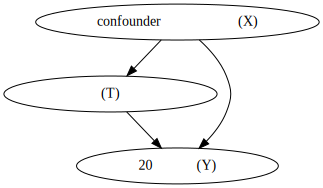

In [2]:
g = gr.Digraph()
g.edge("出门是否购买补刀斧(T)", "玩家第20分钟经济(Y)")
g.edge("confounder，比如天梯段位(X)", "出门是否购买补刀斧(T)")
g.edge("confounder，比如天梯段位(X)", "玩家第20分钟经济(Y)")
g

## PSM核心思想

不直接控制confounders（维数灾难），而是控制confounders确定样本是否成为Treatment的概率p(X)，也就是PSM中的PS——propensity score。

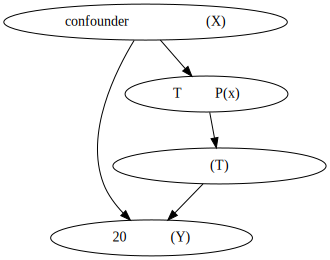

In [3]:
g = gr.Digraph()
g.edge("出门是否购买补刀斧(T)", "玩家第20分钟经济(Y)")
g.edge("confounder，比如天梯段位(X)", "接受T的概率P(x)")
g.edge("接受T的概率P(x)", "出门是否购买补刀斧(T)")
g.edge("confounder，比如天梯段位(X)", "玩家第20分钟经济(Y)")
g

## 如何用confounders来预测T？

一般用逻辑回归就行了，这里不展开讲，可以在这些地方学习：
 - [机器学习课程](https://www.coursera.org/learn/machine-learning)
 - [知乎文章](https://zhuanlan.zhihu.com/p/74874291)
 - [一个用逻辑回归，根据阵容预测DOTA2对局胜负的例子](https://github.com/andreiapostoae/dota2-predictor)
 
这里只需要关注：用逻辑回归训练通过X预测T的模型之后，可以得到X成为T的概率，这个概率就是PS（propensity score）。

接下来是PSM的实现代码

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parents[0]))
import pandas as pd
import requests
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
from utils import get_db_engine, get_proxies, get_api_json, parallel_run_api, get_hero_sample_match

dota2_hero_df = pd.read_sql("select * from hero", con=get_db_engine())
dota2_hero_id_to_name = { str(r['hero_id']): r['hero_name'] for _, r in dota2_hero_df.iterrows() }
dota2_hero_name_to_id = { r['hero_name']: str(r['hero_id']) for _, r in dota2_hero_df.iterrows() }
dota2_hero_df.head(1)

,hero_id,ingame_name,en_official_name,primary_attr,attack_type,roles,legs,en_name,hero_name
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"{Carry,Escape,Nuker}",2,antimage,敌法师


In [7]:
dr_df = pd.read_sql("select * from hero_dr_sample_info", con = get_db_engine())
dr_df = dr_df[dr_df["hero_id"].astype(str) == dota2_hero_name_to_id["卓尔游侠"]]
rank_dr_df = dr_df[~dr_df["rank_tier"].isna()]
rank_dr_df.head(1)

,match_id,hero_id,rank_tier,party_size,creeps_stacked,camps_stacked,gold_per_min,total_gold,firstblood_claimed,randomed,...,begin_buy_quelling_blade,begin_buy_boots,pick_order,has_cosmetic,kills_20_min,camp_gold_adv_20_min,last_hits_6_min,deny_6_min,gold_20_min,xp_20_min
10,6307479438,6,41.0,1,2,2,477,16408,0,False,...,0,0,4,0,0,-1339,26,16,1783,1625


In [9]:
rank_dr_df["treatment"] = rank_dr_df.begin_buy_quelling_blade.apply(lambda x: 1 if x == 1 else 0)
rank_dr_df

,match_id,hero_id,rank_tier,party_size,creeps_stacked,camps_stacked,gold_per_min,total_gold,firstblood_claimed,randomed,...,begin_buy_boots,pick_order,has_cosmetic,kills_20_min,camp_gold_adv_20_min,last_hits_6_min,deny_6_min,gold_20_min,xp_20_min,treatment
10,6307479438,6,41.0,1,2,2,477,16408,0,False,...,0,4,0,0,-1339,26,16,1783,1625,0
26,6308351545,6,51.0,2,3,1,551,26218,0,False,...,0,8,1,1,-1785,23,10,1536,1366,1
47,6307743729,6,34.0,1,2,1,534,22454,0,False,...,0,7,1,5,-1187,20,6,1857,1451,0
66,6307030588,6,80.0,3,0,0,654,29342,0,False,...,0,7,1,7,2406,38,9,2693,2470,1
92,6307872985,6,42.0,3,5,2,574,18406,0,False,...,0,8,1,3,5989,26,8,1882,1968,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95926,6307110241,6,51.0,2,0,0,464,19720,0,False,...,0,4,1,5,-464,14,5,1251,1549,1
95953,6307257349,6,51.0,1,0,0,472,22058,0,False,...,0,7,1,4,-1804,25,11,1710,2639,0
95964,6307636817,6,24.0,1,2,1,509,17950,0,False,...,0,7,1,1,4020,21,4,1541,1678,1
96002,6308280146,6,35.0,1,2,1,590,26825,0,False,...,0,5,1,3,-1193,22,9,1930,1646,0


In [19]:
# rank_dr_df.iloc[0]
rank_dr_df.isnull().sum()

match_id                       0
hero_id                        0
rank_tier                      0
party_size                     0
creeps_stacked                 0
camps_stacked                  0
gold_per_min                   0
total_gold                     0
firstblood_claimed             0
randomed                       0
repicked                    4182
skill                       1027
camp                           0
hero_name                      0
lane_role                      0
begin_buy_quelling_blade       0
begin_buy_boots                0
pick_order                     0
has_cosmetic                   0
kills_20_min                   0
camp_gold_adv_20_min           0
last_hits_6_min                0
deny_6_min                     0
gold_20_min                    0
xp_20_min                      0
treatment                      0
dtype: int64

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1592.2923,6.848,232.522,0.000,1578.867,1605.718
begin_buy_quelling_blade,87.9679,9.131,9.634,0.000,70.066,105.870


Original Sample Size 4182
Treated Population Sample Size 4171.691535553065
Untreated Population Sample Size 4202.820846151649


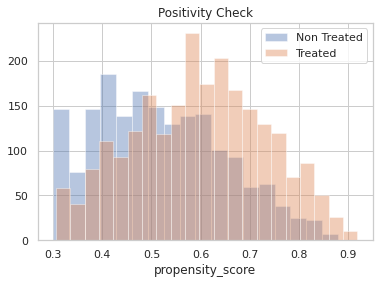

In [28]:
w_df = rank_dr_df.copy()
feature_columns = ["rank_tier", "party_size", "creeps_stacked", "camps_stacked", "firstblood_claimed", "pick_order", "has_cosmetic"]

# ""lane_role"" "skill"
T = 'begin_buy_quelling_blade'
Y = 'gold_20_min'
X = [ f"{c}_standardization" for c in feature_columns ]

display(smf.ols(f"{Y} ~ {T}", data=w_df).fit().summary().tables[1])

for c in feature_columns:
    w_df[[f"{c}_standardization"]] = StandardScaler().fit_transform(w_df[[c]])

ps_model = LogisticRegression(C=1e6).fit(w_df[X], w_df[T])

w_df_ps = w_df.assign(propensity_score=ps_model.predict_proba(w_df[X])[:, 1])

weight_t = 1/w_df_ps.query(f"{T}==1")["propensity_score"]
weight_nt = 1/(1-w_df_ps.query(f"{T}==0")["propensity_score"])
print("Original Sample Size", w_df.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

plt.figure()
sns.distplot(w_df_ps.query(f"{T}==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(w_df_ps.query(f"{T}==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

重叠非常重要！不重叠就不可比：比如假赛低段位玩家完全不出补刀斧，那么ps=0，在高段位的样本中，就找不到ps=0的样本。

In [50]:
weight = ((w_df_ps[T]-w_df_ps["propensity_score"]) /
          (w_df_ps["propensity_score"]*(1-w_df_ps["propensity_score"])))

y1 = sum(w_df_ps.query(f"{T}==1")[Y]*weight_t) / len(w_df)
y0 = sum(w_df_ps.query(f"{T}==0")[Y]*weight_nt) / len(w_df)

ate = np.mean(weight * w_df_ps[Y])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", np.mean(weight * w_df_ps[Y]))
print(f"ATE %: {np.mean(weight * w_df_ps[Y]) / y0:0.2%}")

Y1: 1659.1606041441369
Y0: 1628.0809604848475
ATE 31.079643659292316
ATE %: 1.91%


延伸阅读：https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/